# Rt profile multicategorical versus uniform

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import stan
import arviz as az
import nest_asyncio
import seaborn as sns
nest_asyncio.apply()

num_timepoints = 100 # number of days for incidence data
num_categories = 2

## Parameterize example branching process model with disagregated data

In [2]:
# Build the serial interval w_s
serial_intervals = []

ws_mean_cat = [15.3, 15.3]
ws_std_cat = [9.3, 9.3]

for ws_mean, ws_std in zip(ws_mean_cat, ws_std_cat):
    theta = ws_std**2 / ws_mean
    k = ws_mean / theta
    w_dist = scipy.stats.gamma(k, scale=theta)
    disc_w = w_dist.pdf(np.arange(70))

    serial_intervals.append(disc_w)

serial_intervals = np.array(serial_intervals)

average_serial_interval = np.mean(serial_intervals, axis=0)

# Simulate incidence data
initial_r = 1

# contact_matrix = contact_matrix
contact_matrix = np.array([[0, 16.], [8., 0]])
# contact_matrix = 1 * np.ones((2, 2))

transmissibility = [1, 0.78]
# transmissibility = [1.5, 1.5]

m = branchpro.MultiCatPoissonBranchProModel(
    initial_r, serial_intervals, num_categories, contact_matrix, transmissibility, multipleSI=True)
new_rs = [0.35, 0.05, 0.1]          # sequence of R_0 numbers
start_times = [0, 37, 70]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = [40, 60] # initial number of cases
times = np.arange(num_timepoints)

desagg_cases = m.simulate(parameters, times, var_contacts=False)
agg_cases = np.sum(desagg_cases, axis=1)

print(desagg_cases)

[[ 40.  60.]
 [  0.   0.]
 [  2.   0.]
 [  8.   1.]
 [  2.   3.]
 [  5.   3.]
 [  6.   2.]
 [  9.   5.]
 [ 21.   7.]
 [ 13.   6.]
 [ 18.  10.]
 [ 14.   9.]
 [ 17.  15.]
 [ 17.  13.]
 [ 19.  16.]
 [ 14.  16.]
 [ 29.  14.]
 [ 25.  17.]
 [ 21.  19.]
 [ 30.  29.]
 [ 25.  33.]
 [ 33.  27.]
 [ 34.  37.]
 [ 38.  35.]
 [ 48.  49.]
 [ 66.  43.]
 [ 52.  49.]
 [ 72.  53.]
 [ 54.  61.]
 [ 87.  59.]
 [ 86.  71.]
 [101.  72.]
 [126.  88.]
 [117.  90.]
 [121.  95.]
 [143. 108.]
 [140. 117.]
 [148. 116.]
 [ 25.  31.]
 [ 29.  22.]
 [ 23.  26.]
 [ 33.  28.]
 [ 38.  24.]
 [ 33.  29.]
 [ 35.  27.]
 [ 39.  24.]
 [ 31.  40.]
 [ 33.  22.]
 [ 29.  31.]
 [ 28.  26.]
 [ 50.  28.]
 [ 31.  20.]
 [ 30.  14.]
 [ 30.  17.]
 [ 37.  16.]
 [ 35.  17.]
 [ 26.  19.]
 [ 28.  16.]
 [ 20.  25.]
 [ 26.  26.]
 [ 15.  15.]
 [ 26.  15.]
 [ 21.  21.]
 [ 22.  20.]
 [ 22.  24.]
 [ 16.  22.]
 [ 21.  16.]
 [ 24.  14.]
 [ 18.  10.]
 [ 14.  17.]
 [ 19.  10.]
 [ 34.  25.]
 [ 22.  23.]
 [ 19.  22.]
 [ 26.  25.]
 [ 30.  19.]
 [ 26.  22.]

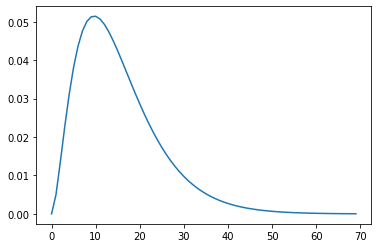

In [3]:
plt.plot(serial_intervals[0, :])

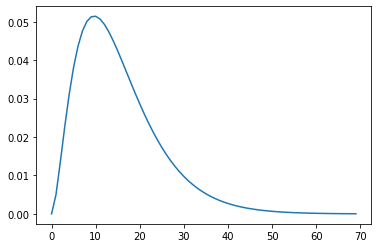

In [4]:
plt.plot(serial_intervals[1, :])

## Plot agreggated local incidence numbers

In [5]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=agg_cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## R_t inference using STAN

In [6]:
# Compute the eigenvalues of the maximum effective contact matrix
eff_contact_matrix = np.matmul(contact_matrix, np.diag(transmissibility))

spec_radius = np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix)))

# Compute stability criterion using last change in growth rate
stability_criterion = new_rs[-1] * spec_radius

print(stability_criterion)

0.9991996797437438


In [7]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

# Correction for overall reproduction number
# Imperfect contacts
eff_contact_matrix = np.matmul(contact_matrix, np.diag(transmissibility))
correc_i = np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix)))

In [8]:
# Transform our incidence data into pandas dataframes
multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        desagg_cases[:, _]

multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': agg_cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, start_times[2]+1))
L3 = len(np.arange(start_times[2]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': [new_rs[0]*correc_i] * L1 + [new_rs[1]*correc_i] * L2 + [new_rs[2]*correc_i] * L3
})

## Divergence of Means

In [9]:
mean_ratios = []
uni_rate = []
multi_rate = []
shape = []
for t in np.arange(R_t_start, num_timepoints):
    shape.append( a + math.fsum(agg_cases[(t-tau):(t+1)]))
    uni_cat_sum_var = 0
    for k in range(t-tau,t+1):
        if k > len(average_serial_interval):
            vec1 = agg_cases[(k-1):(k - len(average_serial_interval) - 1):-1] # I_(k-1), ... , I_0
            vec2 = average_serial_interval # w_1, ... , w_k
        else:
            vec1 = agg_cases[(k-1)::-1] # I_(k-1), ... , I_0
            vec2 = average_serial_interval[:k] # w_1, ... , w_k
        uni_cat_sum_var += math.fsum( np.multiply(vec1,vec2) )
    uni_cat_rate = 1/b + uni_cat_sum_var

    multi_cat_sum_var = 0
    for k_inx, k in enumerate(range(t-tau,t+1)):
        for i in range(num_categories):
            if k > serial_intervals.shape[1]:
                vec1 = desagg_cases[(k-1):(k - serial_intervals.shape[1] - 1):-1, :] # I_(k-1), ... , I_0
                vec2 = serial_intervals[:, :k] # w_1, ... , w_k
            else:
                vec1 = desagg_cases[(k-1)::-1, :] # I_(k-1), ... , I_0
                vec2 = serial_intervals[:, :k] # w_1, ... , w_k
            sub_sum = np.matmul(transmissibility, np.matmul(vec2,vec1))
            multi_cat_sum_var += np.sum(np.multiply(contact_matrix[i, :], sub_sum))  # vector of sum^k_{s=0} w_s I_{k-s}
    multi_cat_rate = 1/b + multi_cat_sum_var /spec_radius

    print(uni_cat_rate, multi_cat_rate)

    mean_ratios.append(uni_cat_rate / multi_cat_rate)
    uni_rate.append(uni_cat_rate)
    multi_rate.append(multi_cat_rate)

mean_ratio = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': 100 * np.asarray(mean_ratios)
})

21.06596353297213 41.23866384867602
26.44024946938081 53.178243054892086
31.894551543987767 65.16487011379078
37.101858627431234 76.37809601403632
42.05398711085545 86.73470913571887
46.853773057885185 96.44716507994804
51.648712875522264 105.83930305105623
56.622613029919094 115.33552726599197
61.960228745750975 125.38103469953755
67.81724394326295 136.36710880301604
74.22203276591374 148.46682826341535
81.21172008910649 161.82145185752773
88.81532650570404 176.51955668953656
97.04144520960293 192.61230488947604
105.94137078742077 210.23672632127585
115.59934155493335 229.6298993656333
126.0860540647302 250.96883841369848
137.52731135050647 274.5225765642023
150.03192223422215 300.5574451463035
163.78310323046983 329.5128650606101
179.09128319274672 361.98817237830923
196.17148154483814 398.35978794577574
215.23279128816014 438.93174090904756
236.4418647544008 484.00837804710784
259.98588132949357 533.8868916130087
286.11205319797244 588.9823466879119
315.0260345897686 649.59835496209

In [10]:
# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(uni_rate) == num_timepoints - tau
len(multi_rate) == num_timepoints - tau

mean_uni = np.divide(shape, uni_rate)
mean_multi = np.divide(shape, multi_rate)

uni_post_dist = scipy.stats.gamma(shape,scale = 1/np.array(uni_rate))
uni_post_dist_interval = uni_post_dist.interval(.95)

multi_post_dist = scipy.stats.gamma(shape,scale = 1/np.array(multi_rate))
multi_post_dist_interval = multi_post_dist.interval(.95)

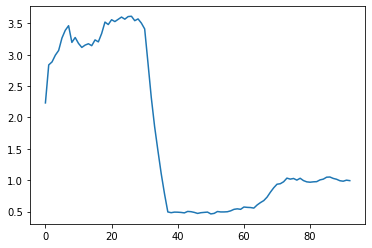

In [12]:
plt.plot(uni_post_dist.mean())

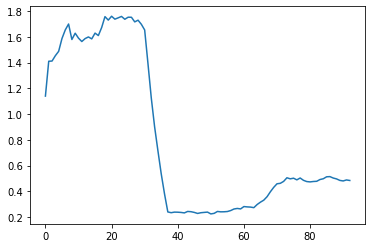

In [13]:
plt.plot(multi_post_dist.mean())

In [14]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(mean_ratio)    
fig.update_labels(time_label='Time (Day)', r_label='Ratio(%)')
fig.figure.update_layout(title_text='Multi-categorical versus Standard')

fig.show_figure()

## 1. Contact Tracing + Desaggregated data + Poisson Branching process with multiple categories

In [12]:
approx_multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int i, int t, array [,] real aI, array [,] real aSI,
        array [,] real C, array [] real transm) {
            real mean;

            mean = 0;
            for(j in 1:n){
                if(t > S) {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[(t-S):(t-1), j], aSI[j, :]) /
                        normalizing_const(aSI[j, :]));
                }
                else {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[:(t-1), j], aSI[j, (S-t+2):]) /
                        normalizing_const(aSI[j, :]));
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    real rho_EC; // spectral radius effective contact matrix
    array [n] real transm; // transmissibility vector
    array [N, n] int I; // local incidences for N days
    int tau; // sliding window
    array [n, S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for (i in 1:n){
            for(k in (t-tau+1):(t+1)) {
                if (effective_no_infectives(N, S, n, i, k, I, revSI, C, transm) != 0) {
                    I[k, i] ~ poisson (
                        R[t-tau] / rho_EC * effective_no_infectives(
                            N, S, n, i, k, I, revSI, C, transm)); // likelihood
                        }
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

approx_multicat_data = {
    'N': num_timepoints,
    'S': serial_intervals.shape[1],
    'n': num_categories,
    'C': contact_matrix,
    'rho_EC': correc_i,
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_intervals[:, ::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_22889/3050155256.py:69: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [ ]:
posterior = stan.build(
    approx_multicat_model, data=approx_multicat_data, random_seed=10)

# Extract the user-defined function
effective_no_infectives = posterior.extract('effective_no_infectives')['effective_no_infectives']

# Now you can use my_function in Python
result = effective_no_infectives(5)
print(result)  # Output should be 25

In [13]:
posterior = stan.build(
    approx_multicat_model, data=approx_multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=20)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2800/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   3.115  0.799   1.676    4.627      0.013    0.009    3337.0    1668.0   
R[1]   3.906  0.745   2.655    5.398      0.012    0.008    4101.0    2117.0   
R[2]   3.813  0.681   2.527    5.044      0.011    0.008    3997.0    2207.0   
R[3]   3.643  0.634   2.577    4.939      0.009    0.007    4473.0    1909.0   
R[4]   3.325  0.564   2.216    4.326      0.009    0.007    3870.0    2146.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
R[88]  0.974  0.105   0.774    1.163      0.002    0.001    4489.0    2185.0   
R[89]  0.986  0.103   0.788    1.166      0.002    0.001    3765.0    2155.0   
R[90]  0.854  0.093   0.685    1.024      0.001    0.001    4191.0    2510.0   
R[91]  0.875  0.092   0.705    1.048      0.001    0.001    3980.0    2300.0   
R[92]  0.900  0.094   0.719    1.068      0.001    0.001    4182.0    2322.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
...      ...  
R[88]    1.0  
R[89]    1.0  
R[90]    1.0  
R[91]    1.0  
R[92]    1.0  

[93 rows x 9 columns]

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

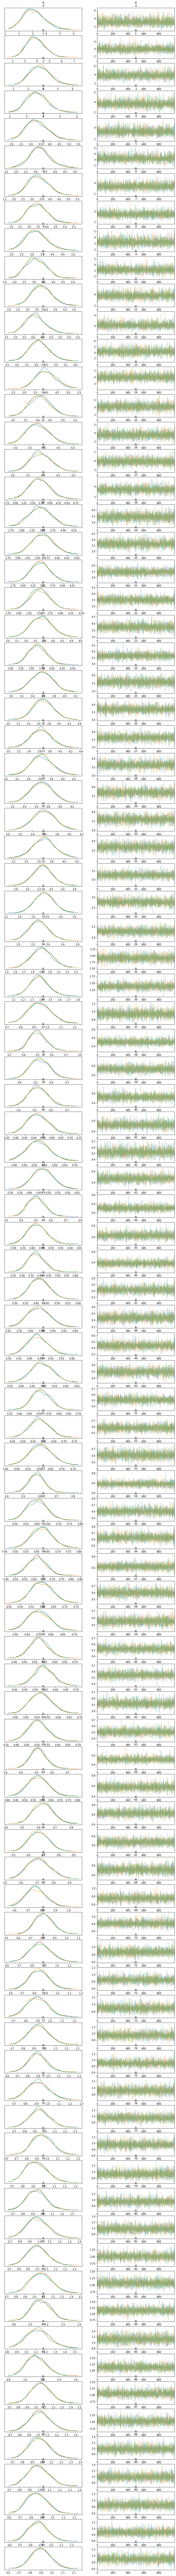

In [14]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [15]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))
approx_multicat_intervals = []


approx_multicat_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2+L3) * [0.95]
})

## 2. Aggregated data + Poisson Branching process

In [16]:
poisson_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

poisson_data = {
    'N': num_timepoints,
    'S': len(average_serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': average_serial_interval[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_22889/3188657703.py:54: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [17]:
posterior = stan.build(
    poisson_model, data=poisson_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  63% (3800/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   2.013  0.503   1.096    2.931      0.008    0.006    3779.0    1825.0   
R[1]   2.492  0.495   1.589    3.426      0.007    0.005    4366.0    1907.0   
R[2]   2.432  0.418   1.701    3.213      0.006    0.005    4176.0    1899.0   
R[3]   2.279  0.394   1.575    2.996      0.006    0.004    4178.0    1992.0   
R[4]   2.043  0.358   1.356    2.668      0.006    0.004    4130.0    2204.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
R[88]  0.780  0.087   0.625    0.952      0.001    0.001    4345.0    2151.0   
R[89]  0.820  0.084   0.675    0.988      0.001    0.001    3876.0    1787.0   
R[90]  0.740  0.082   0.592    0.897      0.001    0.001    4327.0    2172.0   
R[91]  0.789  0.086   0.644    0.965      0.001    0.001    3691.0    2075.0   
R[92]  0.849  0.088   0.687    1.016      0.001    0.001    4349.0    2419.0   

       r_hat  
R[0]    1.00  
R[1]    1.00  
R[2]    1.00  
R[3]    1.00  
R[4]    1.00  
...      ...  
R[88]   1.01  
R[89]   1.00  
R[90]   1.00  
R[91]   1.00  
R[92]   1.00  

[93 rows x 9 columns]

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

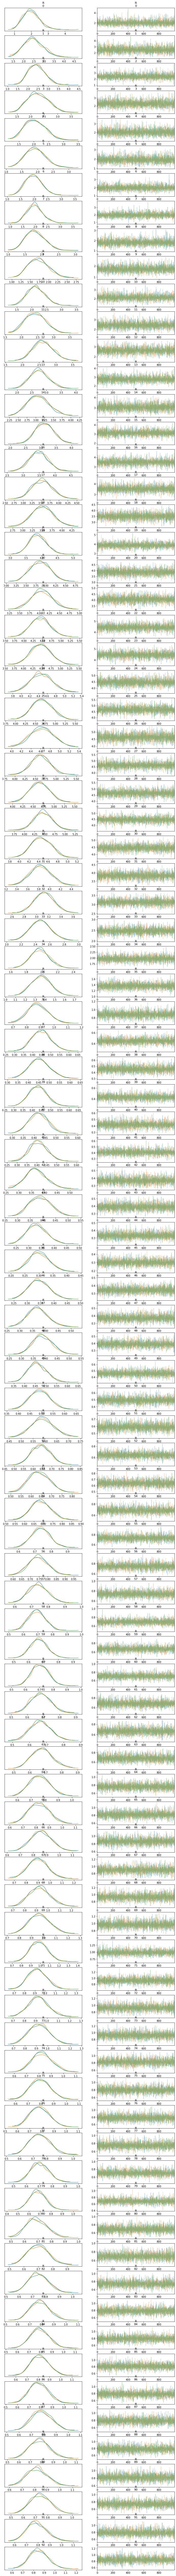

In [18]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [19]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2+L3) * [0.95]
})

## Inference plot using class method results

In [20]:
fig = ReproductionNumberPlot()


fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(approx_multicat_intervals, colour='red', model_type='approximate_contact_tracing multi_categorical')
fig.add_interval_rt(pois_intervals, colour='deepskyblue', model_type='uniform poisson term')
    
fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

